In [240]:
MCPERF_FILENAME = 'mcperf'
JOBS_FILENAME = 'jobs'
INTERVAL_S = 10
MEMCACHED_INITIAL_N_CORES = 1

COLOR_DICTIONARY = {
    "canneal": "#CCCCAA",
    "ferret": "#AACCCA",
    "vips": "#CC0A00",
    "radix": "#00CCA0",
    "dedup": "#CCACCA",
    "freqmine": "#0CCA00",
    "blackscholes": "#CCA000",
}

In [241]:
import re
import pandas as pd
from datetime import datetime

def parse_mcperf(filename):
    with open(filename, 'r') as f:
        mcperf_start_ms_since_epoch = int(f.readline().split(' ')[2])
        mcperf_end_ms_since_epoch = int(f.readline().split(' ')[2])
        mcperf_start = datetime.fromtimestamp(mcperf_start_ms_since_epoch / 1000)
        mcperf_end = datetime.fromtimestamp(mcperf_end_ms_since_epoch / 1000)
        f.readline()
        
        substituted_lines = [re.sub(r"\s+", " ", line).strip()
                            for line in f.readlines()]
        headers = substituted_lines[0].split(" ")

        datapoints = []
        for line in substituted_lines[1:]:
            if line == '':
                break
            datapoint = dict(zip(headers, line.split()))
            datapoints.append(datapoint)

        mcperf_df = pd.DataFrame(data=datapoints)
        mcperf_df = mcperf_df.astype(
            {"#type": str, 'p95': float, 'QPS': float})
    return mcperf_start, mcperf_end, mcperf_df

def parse_jobs(filename):
    events = []
    with open(filename, 'r') as f:
        for line in f.readlines():
            if line.strip() == '':
                continue
            columns = line.strip().split(' ')
            event = {
                'timestamp': datetime.fromisoformat(columns[0]),
                'type': columns[1],
                'job': columns[2]
            }
            if event['type'] == 'start' and event['job'] != 'scheduler':
                event['initial_cores'] = columns[3].strip('[]').split(',')
                event['initial_threads'] = int(columns[4])
            elif event['type'] == 'update_cores':
                event['cores'] = columns[3].strip('[]').split(',')
            elif event['type'] == 'custom':
                event['comment'] = columns[3]
            events.append(event)
    return events

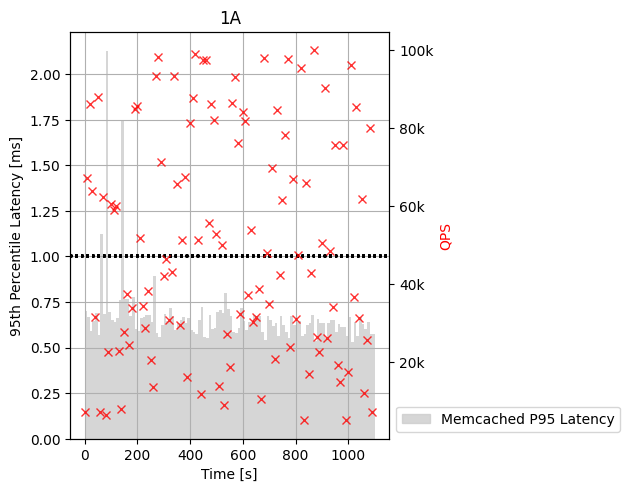

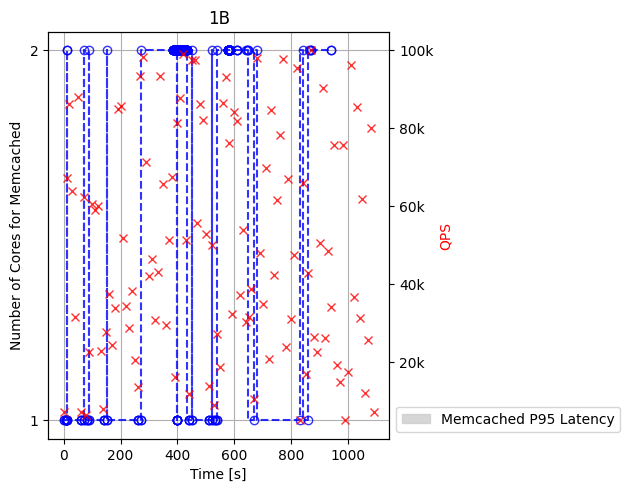

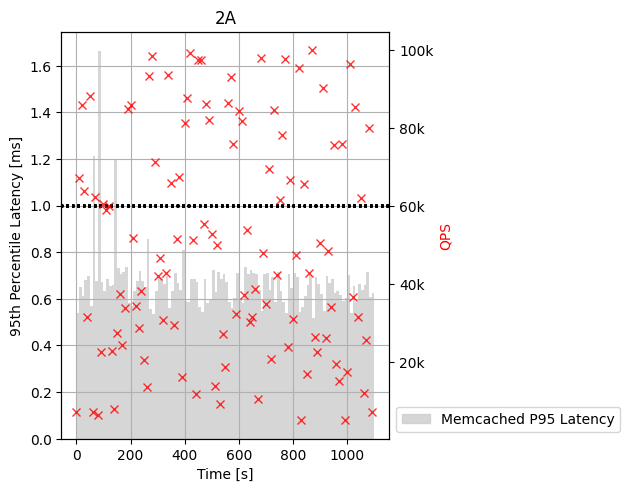

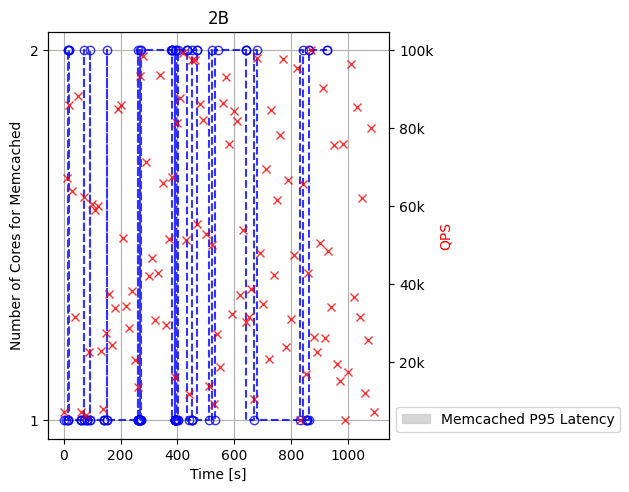

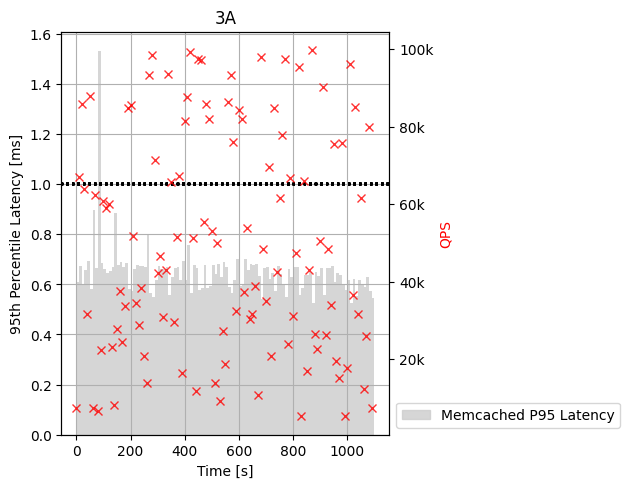

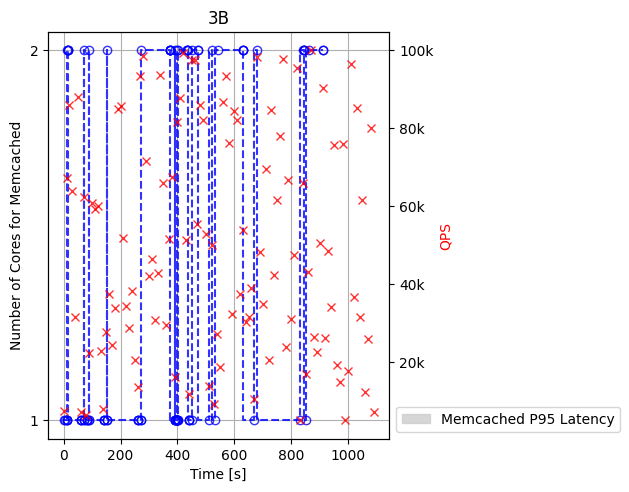

In [243]:
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.patches as mpatches
from matplotlib.ticker import FuncFormatter



def plot(run, type, mcperf_df, events, mcperf_start, mcperf_end):
    # plt.figure(figsize=(10, 5))
    def plotLeftYAxisA(mcperf_df, jobs_df):
        fig, ax1 = plt.subplots()
        for i, row in mcperf_df.iterrows():
            start = i * INTERVAL_S
            end = start + INTERVAL_S
            width = end - start
            latency = float(row["p95"])/1e3

            ax1.bar(
                start,
                latency,
                width=width,
                color="#cccccc",
                align="edge",
                alpha=0.8,
            )

            ax1.set_ylabel("95th Percentile Latency [ms]")
            ax1.set_xlabel("Time [s]")
            ax1.grid(True)
            ax1.axhline(y=1, color='#000', linestyle='dotted')
        return fig, ax1

    def plotLeftYAxisB(mcperf_df, jobs_df):
        core_states = [(0, 1)]
        for event in events:
            time_s = (event['timestamp'] - mcperf_start).total_seconds() + 2 * 3600
            if (event['type'] == 'update_cores' and 
                event['job'] == 'memcached'):
                number_of_cores = len(event['cores'])
            elif (event['type'] == 'start' and
                  event['job'] == 'scheduler'):
                number_of_cores = MEMCACHED_INITIAL_N_CORES
            elif (event['type'] == 'end' and 
                    event['job'] == 'scheduler'):
                    number_of_cores = core_states[-1][1]
            core_states.append((time_s, number_of_cores))
        fig, ax1 = plt.subplots()
        ax1.step(
                [x[0] for x in core_states],
                [x[1] for x in core_states],
                linestyle="--",
                marker='o',
                markerfacecolor='none',
                color="b",
                label="Number of Cores",
                alpha=0.8
            )
        ax1.set_ylabel("Number of Cores for Memcached")
        ax1.set_xlabel("Time [s]")
        ax1.grid(True)
        def y_formatter(x, _):
            return '{:.0f}'.format(x) if x in [1,2] else ''
        ax1.yaxis.set_major_formatter(FuncFormatter(y_formatter))
        ax1.set_yticks([1, 2])
        return fig, ax1

    if type == 'A':
        fig, ax1 = plotLeftYAxisA(mcperf_df, events)
    else:
        fig, ax1 = plotLeftYAxisB(mcperf_df, events)

    ax2 = ax1.twinx()
    ax2.plot(
        mcperf_df.index * INTERVAL_S,
        mcperf_df["QPS"],
        linestyle="none",
        marker='x',
        color="r",
        label="QPS",
        alpha=0.8
    )

    ax2.set_ylabel("QPS", color="r")
    def qps_formatter(x, _):
        return '{:.0f}k'.format(x/1000)
    ax2.yaxis.set_major_formatter(FuncFormatter(qps_formatter))

    md = mpatches.Patch(color="#cccccc", label="Memcached P95 Latency", alpha=0.8)
    patches = [md]
    plt.legend(handles=patches, loc=3, bbox_to_anchor=(1, 0))
    
    fig.tight_layout()
    plt.title(f'{run}{type}')
    plt.savefig(f'plots/plot-4-3_{run}{type}.pdf', bbox_inches='tight')
    plt.show()

# def plotEvents(run, events):
#     workloads = ['ferret', 'dedup', 'canneal', 'freqmine', 'blackscholes', 'radix', 'vips']
#     ax_events.set_yticks(range(6))
#     ax_events.set_yticklabels(workloads)
#     ax_events.set_ylim([-1, 6])
#     ax_events.set_xlim([0, length])
#     ax_events.set_xticks(range(0, length + 1, 100))
#     ax_events.grid(True)

#     for idx, name in enumerate(workloads):
#         entries = events[events['process name'] == name]
#         color = f'C{idx}'
#         if len(entries) % 2 == 1:
#             print(f"Something weird happened...: \n{entries.iloc[-2]}\n but no matching action. Skipping.")

#         for i in range(0, len(entries), 2):
#             if len(entries) % 2 == 1 and i == len(entries) - 3:
#                 ax_events.plot([entries.iloc[i]['timestamp'], entries.iloc[i + 2]['timestamp']],
#                                 [idx, idx], color=color, linewidth=3)
#                 break
#             else:
#                 ax_events.plot([entries.iloc[i]['timestamp'], entries.iloc[i + 1]['timestamp']],
#                             [idx, idx], color=color, linewidth=3)
#         ax_events.scatter([entries.iloc[0]['timestamp']], [idx], c=color, marker='o')
#         ax_events.scatter([entries.iloc[-1]['timestamp']], [idx], c=color, marker='x')


for run in [1, 2, 3]:
    mcperf_path = f'../{MCPERF_FILENAME}_{run}.txt'
    jobs_path = f'../{JOBS_FILENAME}_{run}.txt'

    mcperf_start, mcperf_end, mcperf_df = parse_mcperf(mcperf_path)
    events = parse_jobs(jobs_path)

    plot(run, 'A', mcperf_df, events, mcperf_start, mcperf_end)
    plot(run, 'B', mcperf_df, events, mcperf_start, mcperf_end)
    